# Import

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from shapely import wkt
from shapely.geometry import Point

In [97]:
import seaborn as sns

# EMM data processing

In [3]:
collision = pd.read_csv('data/Motor_Vehicle_Collisions_-_Crashes.csv')
collision.shape

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1896826, 29)

In [4]:
# select EMV type

# Create a list for e-mobility devices
v_elec = ['E-Bike','E-Scooter','ELECTRIC S','E-scooter','E-SKATEBOA','ebike','ESCOOTER S','E-BIKE', 'E-UNICYCLE','E-bike','e skate bo','E bike','ELEC. UNIC','E scooter', 'E-SCOOTER','E-Bik','E-Sco','E bik','e-scooter', 'E BIK', 'E SCO','E-BIK', 'E - B','EBIKE', 'e-bik','e sco', 'ELECTRIC B', 'NIU']

# GET start the df
collision_eco = collision[collision['VEHICLE TYPE CODE 1'].str.contains('E-Bike')==True]

# loop to selet the collision related to e-mobility
for m in range(1,6):
    for i in v_elec:
        df2 = collision[collision['VEHICLE TYPE CODE '+str(m)].str.contains(i)==True]
        collision_eco=collision_eco.append(df2, ignore_index=True)

# drop duplicates
collision_eco = collision_eco.drop_duplicates()
collision_eco.head()

CRASH DATE CRASH TIME    BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0  04/14/2021      17:20      BRONX  10472.0  40.848270 -73.883120   
1  04/16/2021      20:17      BRONX  10451.0  40.827824 -73.919340   
2  04/17/2021      18:00        NaN      NaN  40.864460 -73.918950   
3  04/17/2021      17:50  MANHATTAN  10029.0  40.799984 -73.944855   
4  04/17/2021      19:00        NaN      NaN  40.721985 -73.845230   

                  LOCATION      ON STREET NAME CROSS STREET NAME  \
0    (40.84827, -73.88312)  SOUTHERN BOULEVARD   EAST 182 STREET   
1   (40.827824, -73.91934)      SHERMAN AVENUE   EAST 163 STREET   
2    (40.86446, -73.91895)     WEST 207 STREET               NaN   
3  (40.799984, -73.944855)     EAST 116 STREET    MADISON AVENUE   
4   (40.721985, -73.84523)    QUEENS BOULEVARD           70 ROAD   

  OFF STREET NAME  ...  CONTRIBUTING FACTOR VEHICLE 2  \
0             NaN  ...            Driver Inexperience   
1             NaN  ...                    Unspecified   
2             NaN  ...                            NaN   
3             NaN  ...                    Unspecified   
4             NaN  ...                    Unspecified   

   CONTRIBUTING FACTOR VEHICLE 3  CONTRIBUTING FACTOR VEHICLE 4  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  VEHICLE TYPE CODE 1  \
0                            NaN       4407532               E-Bike   
1                            NaN       4408197               E-Bike   
2                            NaN       4408171               E-Bike   
3                            NaN       4408507               E-Bike   
4                            NaN       4407995               E-Bike   

   VEHICLE TYPE CODE 2  VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4  \
0                Sedan                  NaN                 NaN   
1                Sedan                  NaN                 NaN   
2                  NaN                  NaN                 NaN   
3                  NaN                  NaN                 NaN   
4                 Bike                  NaN                 NaN   

  VEHICLE TYPE CODE 5  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 29 columns]

In [5]:
#sort by time, resulting the collision started in 2012
collision_eco['CRASH DATE'] = pd.to_datetime(collision_eco['CRASH DATE'])
collision_eco.sort_values('CRASH DATE',inplace=True)
# collision_eco
# collision_eco.to_csv('data/Edited/collision_emobility.csv')

# Geodata import

## Community district data
Read in **Community data** and extract MN09 and MN10 for later use.  
  
Comes from: https://www1.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page nycdta2020 file  
Type: Shapefile  
CRS: NAD83 / New York Long Island (ftUS) epsg:2263

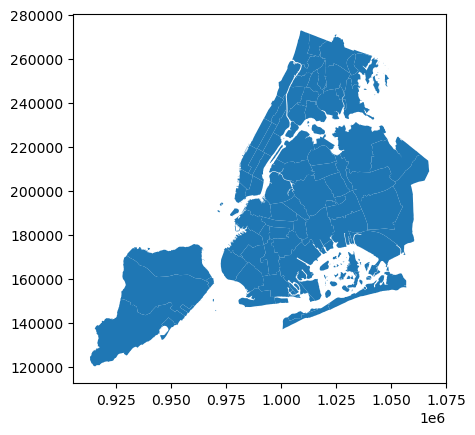

In [10]:
# Communiti district data
nyccdta = gpd.read_file("data/nycdta2020_22a/nycdta2020_22a/nycdta2020.shp")
nyccdta.plot()
plt.show()

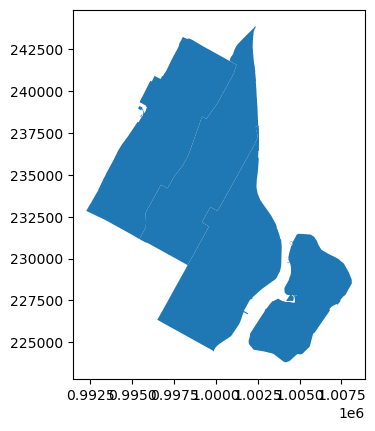

In [11]:
# Extract study area
MN09 = nyccdta.loc[nyccdta['CDTA2020']=='MN09']
MN10 = nyccdta.loc[nyccdta['CDTA2020']=='MN10']
MN11 = nyccdta.loc[nyccdta['CDTA2020']=='MN11']
ls=[MN09, MN10, MN11]

MN = pd.concat(ls)
MN.plot()
plt.show()

## Single-line road data

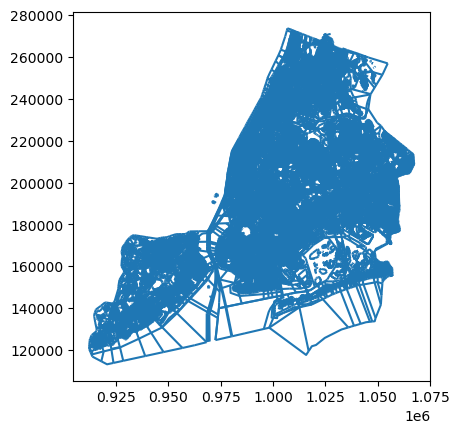

In [12]:
nyc_road = gpd.read_file('data/single_line_formlion/single_line.shp')
nyc_road.plot()
plt.show()

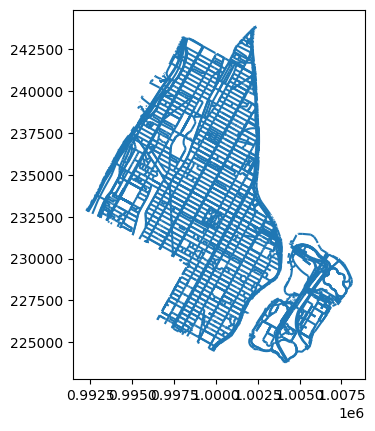

In [13]:
MN_road = gpd.clip(nyc_road, MN, keep_geom_type=False)
MN_road.plot()
plt.show()

## E-mobility Collision data
Collision relate to e-mobility devices.  

In [14]:
emobility = collision_eco.copy()

# convert df to geodf
collisions_e = gpd.GeoDataFrame(
    emobility, geometry=gpd.points_from_xy(emobility.LONGITUDE, emobility.LATITUDE),crs= 4326)

# convert CRS EPSG2263
collisions_e = collisions_e.to_crs(2263)

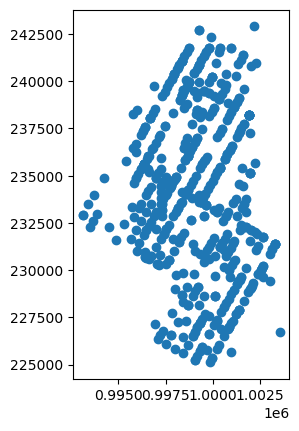

In [16]:
collisions_e_MN = collisions_e.clip(MN)
collisions_e_MN.plot()
plt.show()

In [17]:
# extract study time period
collisions_e_MN.set_index('CRASH DATE', inplace=True, drop=True)
collisions_e_MN = collisions_e_MN['2017/01/01':'2021/12/31']

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:1327: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  result = super().__getitem__(key)


# Functions definition
## Snap point to line ( snapP2L(points) )
source:https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [18]:
def snapP2L(points):
    # Clip MN
    clipped = gpd.clip(points, MN, keep_geom_type=False)

    
    # set bbox for each point
    offset = 150
    bbox = clipped.bounds + [-offset, -offset, offset, offset]
    bbox.head()
    
    # lines hit by bbox
    hits = bbox.apply(lambda row: list(MN_road.sindex.intersection(row)), axis=1)

    #
    tmp = pd.DataFrame({
        # index of points table
        "pt_idx": np.repeat(hits.index, hits.apply(len)),
        # ordinal position of line - access via iloc later
        "line_i": np.concatenate(hits.values)
    })
    
    # Join back to the lines on line_i; we use reset_index() to give us the ordinal position of each line
    tmp = tmp.join(MN_road.reset_index(drop=True), on="line_i")
    
    # Join back to the original points to get their geometry rename the point geometry as "point"
    tmp = tmp.join(clipped.geometry.rename("point"), on="pt_idx")
    
    # Convert back to a GeoDataFrame, so we can do spatial ops
    tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=clipped.crs)
    
    #calculate the distance between each point and each of its associated lines to find the closest one
    tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))
    
    # Discard any lines that are greater than tolerance from points
    # Distance more than 60 are the points at the edge of study area,where the roads has been discarded
    tmp = tmp.loc[tmp.snap_dist <= 60]

    # Sort on ascending snap distance, so that closest goes to top
    tmp = tmp.sort_values(by=["snap_dist"])
    
    # group by the index of the points and take the first, which is the closest line 
    closest = tmp.groupby("pt_idx").first()
    # construct a GeoDataFrame of the closest lines
    closest = gpd.GeoDataFrame(closest, geometry="geometry")
    closest = closest.sort_values(by=["snap_dist"])

    # Position of nearest point from start of the line
    pos = closest.geometry.project(gpd.GeoSeries(closest.point))
    # Get new point location geometry
    new_pts = closest.geometry.interpolate(pos)
    
    #Identify the columns we want to copy from the closest line to the point, such as a line ID.
    line_columns = ['OBJECTID', 'FeatureTyp', 'NonPed', 'StreetCode', 'SegmentID', 'RW_TYPE','BikeLane','geometry']
    # Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
    snapped = gpd.GeoDataFrame(closest[line_columns],geometry='geometry')

    # Join back to the original points:
    points_updated = clipped.drop(columns=["geometry"]).join(snapped)
    # You may want to drop any that didn't snap, if so:
    points_updated = points_updated.dropna(subset=["geometry"])

    return (points_updated)

## Count numbers on roads ( count_num(df, column, num_) )

In [19]:
# Count points on the road segment and merge back to MN_road df
def count_num(df,column, num_):
    count_MN = MN_road
    # Count number on each segment
    grouped = df.groupby('OBJECTID').count()
    num = grouped[column].to_frame()
    #rename the column
    num.columns = [*num.columns[:-1], num_]
    # num.set_axis([*num.columns[:-1], num_], axis=1, inplace=False)
    # num = num.rename(columns={"COLLISION_ID":num_})
    num = num.reset_index()
    
    # Add back to MN_road gdf
    count_MN = pd.merge(MN_road, num,how='left', on=['OBJECTID','OBJECTID'])
    # Fillna as 0
    count_MN[num_] = count_MN[num_].fillna(0)
    # count_MN["COLLISION_ID"] = count_MN["COLLISION_ID"].fillna(0)
    return (count_MN)

## Geopandas read CSV ( df2geo(df,c) )
csv with geometry

In [26]:
def df2geo(df,c):
    df[c] = df[c].apply(wkt.loads)
    df = df.rename(columns={c:'geometry'})
    gdf = gpd.GeoDataFrame(df,crs='epsg:4326')
    gdf = gdf.to_crs(2263)
    return(gdf)

# Overlay road atrributes
## E-collision('num_ecollisions')

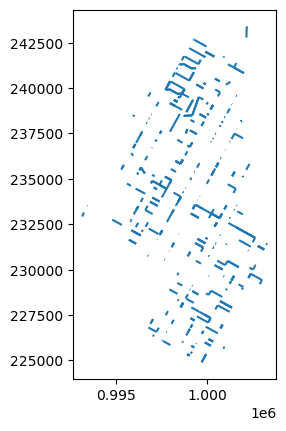

In [22]:
collisions_e_MN_snap = snapP2L(collisions_e_MN)
collisions_e_MN_snap.plot()
plt.show()

In [23]:
MN_road = count_num(collisions_e_MN_snap,'COLLISION_ID','num_ecollisions')

## Leading Pedestrian Interval Signals ( LpedS )

In [24]:
LpedS = gpd.read_file('data/traffic_lights/VZV_Leading Pedestrian Interval Signals/geo_export_280c51c4-2a3b-4f10-98ab-516d938a119f.shp')
LpedS = LpedS.to_crs(2263)

# Snap points to lines
LpedS_snap = snapP2L(LpedS)

# Count numbers on roads
MN_road = count_num(LpedS_snap, 'geometry', 'num_LpedS')
print(MN_road.shape)
# MN_road.head()

(8363, 132)


## Accessible Pedestrian Signals ( ApedS )

In [29]:
ApedS = pd.read_csv('data/traffic_lights/Accessible_Pedestrian_Signal_Locations.csv')

# Change df to geodf
ApedS = df2geo(ApedS,'the_geom')

# Snap points to lines
ApedS_snap = snapP2L(ApedS)

# Count number on roads
MN_road = count_num(ApedS_snap,'geometry','num_ApedS')
print(MN_road.shape)
# MN_road.head()

(8363, 133)


OBJECTID                   Street SAFStreetN FeatureTyp SegmentTyp  \
0  121779.0   WARDS ISLAND SHORELINE       None          2          U   
1  122055.0   WARDS ISLAND SHORELINE       None          2          U   
2  109818.0  ROBERT F KENNEDY BRIDGE       None          0          R   
3  110764.0    WARDS ISLAND GREENWAY       None          0          U   
4  122884.0   WARDS ISLAND SHORELINE       None          2          U   

  IncExFlag RB_Layer NonPed TrafDir TrafSrc  ... ToRight        Join_ID  \
0      None        B   None    None    None  ...       0  1458212010000   
1      None        B   None    None    None  ...       0  1458212010000   
2      None        R      V       W     DOT  ...       0  1442201050000   
3         E        N      D       P    None  ...       0  1017701000000   
4      None        B   None    None    None  ...       0  1458212010000   

  L_PD_Servi R_PD_Servi TRUCK_ROUT  SHAPE_Leng  \
0       None       None       None   90.502646   
1       None       None       None  113.069602   
2       None       None          3   22.249501   
3       None       None       None  951.633377   
4       None       None       None  908.051841   

                                            geometry num_ecollisions  \
0  LINESTRING (1004161.961 223795.353, 1004192.85...             0.0   
1  LINESTRING (1004053.510 223827.337, 1004161.96...             0.0   
2  LINESTRING (1004239.034 223840.739, 1004248.82...             0.0   
3  LINESTRING (1003371.031 224431.174, 1003424.55...             0.0   
4  MULTILINESTRING ((1005164.244 224306.326, 1005...             0.0   

  num_LpedS num_ApedS  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       0.0       0.0  
4       0.0       0.0  

[5 rows x 133 columns]

## Mobile Telecommunications Franchise Pole ( pole )

In [30]:
pole = pd.read_csv('data/traffic_lights/Mobile_Telecommunications_Franchise_Pole_Reservation_Locations.csv')

# Drop poles haven't install
pole = pole.dropna(subset=['Installation Date'])

# df to geodf
pole = gpd.GeoDataFrame(
    pole.drop(['Longitude', 'Latitude'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(pole.Longitude, pole.Latitude)])
pole = pole.to_crs(2263)

# Snap P2L
pole_snap =snapP2L(pole)

# Snapcount number on roads
MN_road = count_num(pole_snap,'geometry','num_pole')

print(MN_road.shape)

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(8363, 134)


## Bus stop shelters (bus)

In [31]:
bus = gpd.read_file('data/Bus Stop Shelters/geo_export_d2b961d8-98b4-43ae-a9b6-b83c65877950.shp')
bus = bus.to_crs(2263)

# Snap points to lines
bus_snap = snapP2L(bus)

# Count numbers on roads
MN_road = count_num(bus_snap, 'geometry','num_bus')

print(MN_road.shape)

(8363, 135)


## Subway Entrances ( subway )

In [32]:
subway = gpd.read_file('data/Subway Entrances/geo_export_a561706b-d41a-4c92-8095-87e3560e8a38.shp')
subway = subway.to_crs(2263)

# Snap points to lines
subway_snap = snapP2L(subway)

# Count numbers on roads
MN_road = count_num(subway_snap, 'geometry','num_subway')

print(MN_road.shape)

(8363, 136)


## Enhanced crosswalk (Encross)

In [33]:
Encross = gpd.read_file('data/VZV_Enhanced Crossings/geo_export_777e82cf-b574-4e73-88b9-736e39bdee17.shp')
Encross = Encross.to_crs(2263)

# Snap points to lines
Encross_snap = snapP2L(Encross)

# Count numbers on roads
MN_road = count_num(Encross_snap, 'geometry','num_Encross')

print(MN_road.shape)

(8363, 137)


## Turn Traffic Calming ( calming )

In [35]:
calming = gpd.read_file('data/VZV_Turn Traffic Calming/geo_export_75e412b3-1e81-4b49-acea-734fc92e75ca.shp')
calming = calming.to_crs(2263)

# Snap points to lines
calming_snap = snapP2L(calming)

# Count numbers on roads
MN_road = count_num(calming_snap, 'geometry','num_calming')

print(MN_road.shape)

(8363, 138)


## Street Trees ( tree )
The original dataset is huge and takes days to process. So I clipped the data in QGIS before hand.

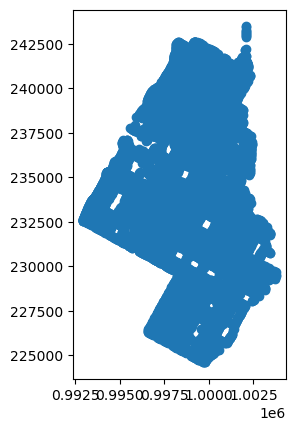

In [36]:
tree = gpd.read_file('data/Edited/MN_trees.shp')
tree = tree.to_crs(2263)
tree.plot()
plt.show()

In [37]:
# Snap points to lines
tree_snap = snapP2L(tree)

# Count numbers on roads
MN_road = count_num(tree_snap, 'geometry','num_tree')

print(MN_road.shape)

(8363, 139)


## Demographics( pop )
The Demographic data is not perfectly correspondence. and no people live on Randall's Island  
The original Demographic data is only in pdf version. It has been convert to xsel and csv version by [i love pdf](https://www.ilovepdf.com/).

In [38]:
Demog_NTAlist = ['MN03','MN04','MN06','MN09','MN11','MN33','MN34'] 
nta_list = ['MN1002','MN0903','MN0902','MN0901','MN1001','MN1101','MN1102']

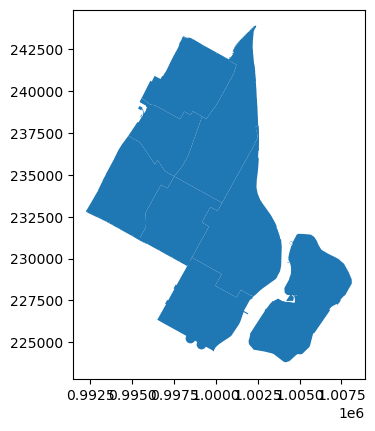

In [40]:
# which NTA does the road in
NTA  = gpd.read_file('data/nynta2020_22a/nynta2020.shp')
NTA_MN  = gpd.clip(NTA, MN, keep_geom_type=False)
NTA_MN.plot()
plt.show()

In [41]:
# Only NTA2020  and geometry is needed
NTA_MN = NTA_MN[['NTA2020','geometry']]

# sjoin give NTA2020 to roads
MN_road2 = gpd.sjoin(MN_road,NTA_MN, how='left').drop_duplicates()
MN_road2 = MN_road2.groupby('OBJECTID',as_index=False).first()

print(MN_road2.shape)

(8363, 141)


E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\pandas\core\groupby\generic.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return self._wrap_agged_manager(new_mgr)


In [42]:
#change NTA2020 to the NTA code of demogra
for i in range(7):    
    MN_road2['NTA2020'] = MN_road2['NTA2020'].replace(nta_list[i],Demog_NTAlist[i])
MN_road2.shape

(8363, 141)

In [44]:
# add population to road
demo = pd.read_csv('data/Edited/Demographics_by_NTA.csv')
demo = demo[['Unnamed: 1','Total populatio n']]
demo

Unnamed: 1 Total populatio n
0     NTA Code               NaN
1          NaN               NaN
2          NaN               NaN
3         BX01            35,560
4         BX03            37,887
..         ...               ...
189       SI45            20,933
190       SI48            26,982
191       SI54            42,306
192       SI99                 -
193        NaN               NaN

[194 rows x 2 columns]

In [45]:
MN_road2 = MN_road2.merge(demo, how='left', left_on='NTA2020',right_on='Unnamed: 1')
MN_road2['Total populatio n'] = MN_road2['Total populatio n'].fillna(0)

In [46]:
#groupby first to avoid a road that cross different area
MN_road2 = MN_road2.groupby('OBJECTID',as_index=False).first()

# drop columns no need
MN_road2 = MN_road2.drop(['NTA2020', 'Unnamed: 1','index_right'], axis=1)
MN_road = MN_road2.rename(columns={'Total populatio n':'pop'})

print(MN_road.shape)

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\pandas\core\groupby\generic.py:1094: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return self._wrap_agged_manager(new_mgr)


(8363, 140)


## Traffic volume (Vol)
huge data, lacking data of 2021.
take near 4 years data as sample.

In [49]:
traffic_v = pd.read_csv('data/Automated_Traffic_Volume_Counts.csv')

In [50]:
# select Manhattan and 2017-2020
traffic_v2 = traffic_v.loc[traffic_v['Boro'] == 'Manhattan']

traffic_v2017 = traffic_v2.loc[traffic_v2['Yr'] == 2017]
traffic_v2018 = traffic_v2.loc[traffic_v2['Yr'] == 2018]
traffic_v2019 = traffic_v2.loc[traffic_v2['Yr'] == 2019]
traffic_v2020 = traffic_v2.loc[traffic_v2['Yr'] == 2020]
temp = [traffic_v2017,traffic_v2018,traffic_v2019,traffic_v2020]
traffic_v2 = pd.concat(temp)

In [51]:
# get max volumn in 3 years for each segment
traffic_v3 = traffic_v2.groupby('SegmentID').max()
traffic_v3 = traffic_v3.reset_index()[['SegmentID','Vol']]

In [52]:
# add traffic volumn to MN_road

# two 'SegmentID' are not same type,change MN_road one to merge
MN_road['SegmentID'] = MN_road[['SegmentID']].astype(int)

MN_road = pd.merge(MN_road,traffic_v3,how='left', on=['SegmentID','SegmentID'])
#only 62 segment has volumn counts

#fillna
MN_road['Vol'] = MN_road['Vol'].fillna(0)

print(MN_road.shape)

(8363, 141)


# Extract needed columns

In [53]:
data_list = ['OBJECTID',
             'NonPed','TrafDir','RW_TYPE','StreetWidt','BikeLane','num_ecollisions','Number_Tra','Number_Par','POSTED_SPE',
             'num_LpedS','num_ApedS','num_pole','num_bus','num_subway','num_Encross','num_tree','pop','Vol',
             'BIKE_TRAFD']

In [54]:
MN_road = MN_road[data_list]
MN_road.head()

OBJECTID NonPed TrafDir RW_TYPE  StreetWidt BikeLane  num_ecollisions  \
0   90743.0   None       W       1        42.0     None              0.0   
1   90744.0   None       T       1         NaN     None              0.0   
2   90746.0   None       T       1        60.0        2              0.0   
3   90747.0   None       W       1        52.0     None              0.0   
4   90748.0   None       T       1         NaN     None              0.0   

  Number_Tra Number_Par POSTED_SPE  num_LpedS  num_ApedS  num_pole  num_bus  \
0          2       None         25        0.0        0.0       0.0      0.0   
1       None       None       None        0.0        0.0       0.0      0.0   
2          4          2         25        1.0        0.0       0.0      0.0   
3          3          2         25        1.0        0.0       0.0      0.0   
4       None       None       None        0.0        0.0       0.0      0.0   

   num_subway  num_Encross  num_tree     pop  Vol BIKE_TRAFD  
0         0.0          0.0       0.0  51,064  0.0       None  
1         0.0          0.0       6.0  23,673  0.0       None  
2         0.0          0.0       5.0  23,673  0.0         TW  
3         0.0          0.0       0.0  59,869  0.0       None  
4         0.0          0.0       4.0  86,117  0.0       None

In [55]:
# add a column contains binary num_crash
bi = MN_road[['num_ecollisions']]
bi = bi.where(bi['num_ecollisions']<1,1)
bi.columns = ['num_ecollisions_B']

In [56]:
# append back to the road df
MN_road = pd.concat([MN_road,bi],axis=1,join='inner')

In [57]:
# convert pop type
def typechange(c):
    MN_road[c]= MN_road[c].replace(',','',regex=True).astype(float)

In [58]:
for i in ['Number_Tra','Number_Par','POSTED_SPE','pop']:
    print(i)
    typechange(i)
MN_road.info()

Number_Tra
Number_Par
POSTED_SPE
pop
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8363 entries, 0 to 8362
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OBJECTID           8363 non-null   float64
 1   NonPed             1894 non-null   object 
 2   TrafDir            7164 non-null   object 
 3   RW_TYPE            7165 non-null   object 
 4   StreetWidt         5635 non-null   float64
 5   BikeLane           1251 non-null   object 
 6   num_ecollisions    8363 non-null   float64
 7   Number_Tra         5635 non-null   float64
 8   Number_Par         3624 non-null   float64
 9   POSTED_SPE         4984 non-null   float64
 10  num_LpedS          8363 non-null   float64
 11  num_ApedS          8363 non-null   float64
 12  num_pole           8363 non-null   float64
 13  num_bus            8363 non-null   float64
 14  num_subway         8363 non-null   float64
 15  num_Encross        8363 non-null   

In [59]:
MN_road.describe()

OBJECTID   StreetWidt  num_ecollisions   Number_Tra   Number_Par  \
count    8363.000000  5635.000000      8363.000000  5635.000000  3624.000000   
mean   107213.935789    37.105235         0.059070     2.052706     1.761313   
std      9074.877219    14.768949         0.388304     1.117466     0.426340   
min     90743.000000    10.000000         0.000000     1.000000     1.000000   
25%    100102.500000    30.000000         0.000000     1.000000     2.000000   
50%    107200.000000    30.000000         0.000000     2.000000     2.000000   
75%    113207.500000    44.000000         0.000000     3.000000     2.000000   
max    125101.000000   120.000000        10.000000    10.000000     2.000000   

        POSTED_SPE    num_LpedS    num_ApedS     num_pole      num_bus  \
count  4984.000000  8363.000000  8363.000000  8363.000000  8363.000000   
mean     26.564005     0.046156     0.007533     0.033600     0.024154   
std       5.417240     0.236621     0.089195     0.187367     0.161137   
min      25.000000     0.000000     0.000000     0.000000     0.000000   
25%      25.000000     0.000000     0.000000     0.000000     0.000000   
50%      25.000000     0.000000     0.000000     0.000000     0.000000   
75%      25.000000     0.000000     0.000000     0.000000     0.000000   
max      50.000000     3.000000     2.000000     2.000000     2.000000   

        num_subway  num_Encross     num_tree           pop          Vol  \
count  8363.000000  8363.000000  8363.000000   8363.000000  8363.000000   
mean      0.009566     0.001076     1.853880  52728.626330     3.266292   
std       0.107834     0.032789     4.327778  26154.402825    29.557261   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.000000     0.000000     0.000000  51064.000000     0.000000   
50%       0.000000     0.000000     0.000000  59869.000000     0.000000   
75%       0.000000     0.000000     2.000000  62810.000000     0.000000   
max       2.000000     1.000000    50.000000  86117.000000   536.000000   

       num_ecollisions_B  
count        8363.000000  
mean            0.033481  
std             0.179899  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000

In [60]:
MN_road = MN_road.fillna(0)

In [61]:
# Encoding of categorical variables
MN_road_numeric = pd.get_dummies(MN_road)
MN_road_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8363 entries, 0 to 8362
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OBJECTID           8363 non-null   float64
 1   StreetWidt         8363 non-null   float64
 2   num_ecollisions    8363 non-null   float64
 3   Number_Tra         8363 non-null   float64
 4   Number_Par         8363 non-null   float64
 5   POSTED_SPE         8363 non-null   float64
 6   num_LpedS          8363 non-null   float64
 7   num_ApedS          8363 non-null   float64
 8   num_pole           8363 non-null   float64
 9   num_bus            8363 non-null   float64
 10  num_subway         8363 non-null   float64
 11  num_Encross        8363 non-null   float64
 12  num_tree           8363 non-null   float64
 13  pop                8363 non-null   float64
 14  Vol                8363 non-null   float64
 15  num_ecollisions_B  8363 non-null   float64
 16  NonPed_0           8363 

In [62]:
# manually choose the reference level for each categorical variable and exclude them from the DataFrame
road_final = MN_road_numeric.drop(['NonPed_0','RW_TYPE_0','TrafDir_0','BikeLane_0'],axis=1)
road_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8363 entries, 0 to 8362
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OBJECTID           8363 non-null   float64
 1   StreetWidt         8363 non-null   float64
 2   num_ecollisions    8363 non-null   float64
 3   Number_Tra         8363 non-null   float64
 4   Number_Par         8363 non-null   float64
 5   POSTED_SPE         8363 non-null   float64
 6   num_LpedS          8363 non-null   float64
 7   num_ApedS          8363 non-null   float64
 8   num_pole           8363 non-null   float64
 9   num_bus            8363 non-null   float64
 10  num_subway         8363 non-null   float64
 11  num_Encross        8363 non-null   float64
 12  num_tree           8363 non-null   float64
 13  pop                8363 non-null   float64
 14  Vol                8363 non-null   float64
 15  num_ecollisions_B  8363 non-null   float64
 16  NonPed_D           8363 

In [64]:
road_final = road_final.fillna('0').astype(int)

In [63]:
# fill na
road_final = road_final.fillna('0').astype(int)

## Dealing with multicollinearity

In [65]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [66]:
road_afterVIF = drop_column_using_vif_(road_final.drop(['num_ecollisions','num_ecollisions_B'],axis=1))
print("The columns remaining after VIF selection are:")
print(road_afterVIF.columns)

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: BIKE_TRAFD_0
Dropping: RW_TYPE_1
Dropping: StreetWidt
Dropping: TrafDir_P
The columns remaining after VIF selection are:
Index(['OBJECTID', 'Number_Tra', 'Number_Par', 'POSTED_SPE', 'num_LpedS',
       'num_ApedS', 'num_pole', 'num_bus', 'num_subway', 'num_Encross',
       'num_tree', 'pop', 'Vol', 'NonPed_D', 'NonPed_V', 'TrafDir_A',
       'TrafDir_T', 'TrafDir_W', 'RW_TYPE_10', 'RW_TYPE_12', 'RW_TYPE_13',
       'RW_TYPE_2', 'RW_TYPE_3', 'RW_TYPE_4', 'RW_TYPE_6', 'RW_TYPE_7',
       'RW_TYPE_8', 'RW_TYPE_9', 'BikeLane_1', 'BikeLane_11', 'BikeLane_2',
       'BikeLane_3', 'BikeLane_4', 'BIKE_TRAFD_FT', 'BIKE_TRAFD_TF',
       'BIKE_TRAFD_TW'],
      dtype='object')


In [68]:
new_x = road_final[['Number_Tra','num_LpedS','num_ApedS','num_pole','num_bus',
                    'num_subway','num_Encross','num_tree','pop','Vol',
                    'NonPed_D','TrafDir_A','TrafDir_T','RW_TYPE_10','RW_TYPE_3',
                    'RW_TYPE_4','RW_TYPE_6','RW_TYPE_7','RW_TYPE_8','RW_TYPE_9',
                    'BikeLane_1','BikeLane_11','BikeLane_2','BikeLane_3','BikeLane_4','num_ecollisions_B']]
new_x['num_pedS'] = new_x['num_LpedS'] + new_x['num_ApedS']
new_x = new_x.drop(columns=['num_LpedS','num_ApedS'])
new_x

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Number_Tra  num_pole  num_bus  num_subway  num_Encross  num_tree    pop  \
0              2         0        0           0            0         0  51064   
1              0         0        0           0            0         6  23673   
2              4         0        0           0            0         5  23673   
3              3         0        0           0            0         0  59869   
4              0         0        0           0            0         4  86117   
...          ...       ...      ...         ...          ...       ...    ...   
8358           0         0        0           0            0        10  53094   
8359           0         0        0           0            0         0  53094   
8360           0         0        0           0            0         0  53094   
8361           0         0        0           0            0         0  59869   
8362           0         0        0           0            0         0  59869   

      Vol  NonPed_D  TrafDir_A  ...  RW_TYPE_7  RW_TYPE_8  RW_TYPE_9  \
0       0         0          0  ...          0          0          0   
1       0         0          0  ...          0          0          0   
2       0         0          0  ...          0          0          0   
3       0         0          0  ...          0          0          0   
4       0         0          0  ...          0          0          0   
...   ...       ...        ...  ...        ...        ...        ...   
8358    0         0          0  ...          0          0          0   
8359    0         0          0  ...          0          0          0   
8360    0         0          0  ...          0          0          0   
8361    0         0          0  ...          0          0          0   
8362    0         0          0  ...          0          0          0   

      BikeLane_1  BikeLane_11  BikeLane_2  BikeLane_3  BikeLane_4  \
0              0            0           0           0           0   
1              0            0           0           0           0   
2              0            0           1           0           0   
3              0            0           0           0           0   
4              0            0           0           0           0   
...          ...          ...         ...         ...         ...   
8358           0            0           0           0           0   
8359           0            0           0           0           0   
8360           0            0           0           0           0   
8361           0            0           0           0           0   
8362           0            0           0           0           0   

      num_ecollisions_B  num_pedS  
0                     0         0  
1                     0         0  
2                     0         1  
3                     0         1  
4                     0         0  
...                 ...       ...  
8358                  0         1  
8359                  0         0  
8360                  0         1  
8361                  0         0  
8362                  1         0  

[8363 rows x 25 columns]

In [69]:
new_x.to_csv('data/Edited/new_x.csv')

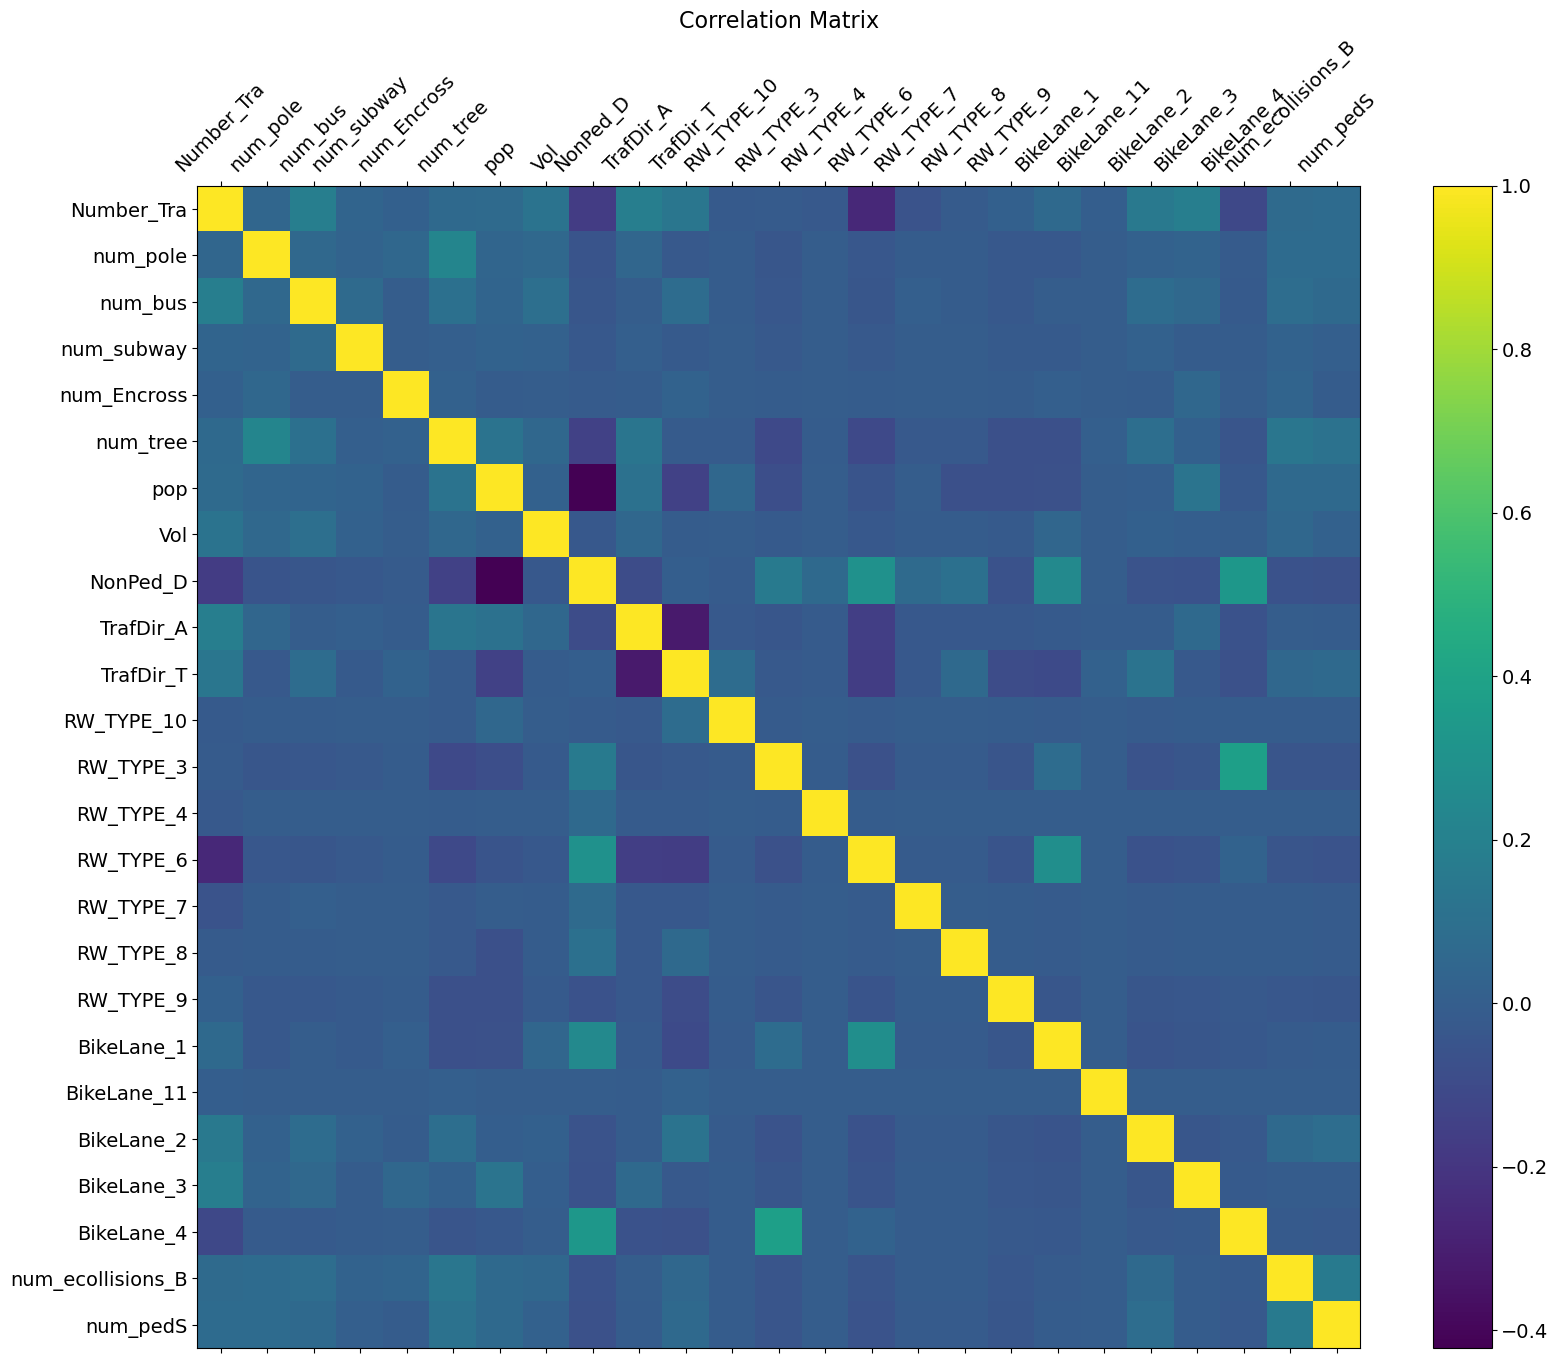

In [72]:
# Checking correlations
x_values = new_x
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(x_values.corr(), fignum=f.number)
plt.xticks(range(x_values.shape[1]), x_values.columns, fontsize=14, rotation=45)
plt.yticks(range(x_values.shape[1]), x_values.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.savefig('plot/correlation')
plt.show()

# Plot
## Road map

In [73]:
MN_road_geo = MN_road.merge(nyc_road[['OBJECTID','geometry']],left_on='OBJECTID',right_on='OBJECTID',how='left')
MN_road_geo = pd.concat([MN_road_geo,new_x[['num_pedS']]],axis=1)

MN_road_geo = gpd.GeoDataFrame(
    MN_road_geo, geometry='geometry',crs= 2263)

MN_road_geo = MN_road_geo.to_crs(4326)

In [74]:
cata_val = ['NonPed', 'TrafDir','RW_TYPE','BikeLane','BIKE_TRAFD', 'num_ecollisions_B','num_ecollisions', 'Number_Tra',   'num_pedS', 'num_pole', 'num_bus', 'num_subway',
             'num_Encross', 'pop']
cata_lable = ['Non-Pedstrian Indicator','Traffic Directions','Roadway Type','Bikelane'
              ,'Bike Traffic Direction','EMM Collision happen','EMM Collisions','Travel Lanes','Pedestrian Signals','Mobile Telecommunication Franchise pole','Bus Stop Shelters','Subway Entrances','Enhanced Crosswalk','Population']
conti_val = ['num_ecollisions', 'num_tree','Vol']
conti_lable =['EMM Crash Count','Street Trees','Traffic Volumn']

In [75]:
# replace featureType if have time
# change datatype of ecollsion B
def change2ob(s):
    MN_road_geo[s] = MN_road_geo[s].astype(object)
    
for i in cata_val:
    change2ob(i)

In [76]:
def conti_plot(column, lable_name,colour='coolwarm'):
    cmap = plt.cm.get_cmap(colour)
    ax = MN_road_geo.plot(linewidth = 0.1, color = cmap(0), alpha=0.5)
    MN_road_geo.plot(column=column,cmap=cmap,
                         linewidth = 1, 
                         ax=ax,legend=True)
    
    plt.title(lable_name)
    plt.savefig('plot/conti_'+lable_name)
    return plt.show()

def cata_plot(column, lable_name,colour='coolwarm'):
    cmap = plt.cm.get_cmap(colour)
    ax = MN_road_geo.plot(linewidth = 0.1, color = cmap(0), alpha=0.5)
    MN_road_geo.plot(column=column,cmap=cmap,
                         linewidth = 1, 
                         ax=ax,legend=True)
    plt.title(lable_name)
    plt.savefig('plot/cata_'+lable_name,bbox_inches = 'tight')
    return plt.show()

In [77]:
for i in conti_val[2:15]:
    MN_road_geo[i] = MN_road_geo[[i]].astype(object)

0EMM Crash Count


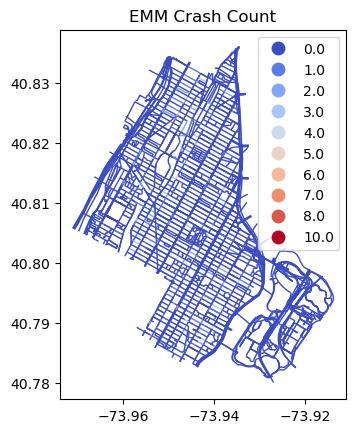

1Street Trees


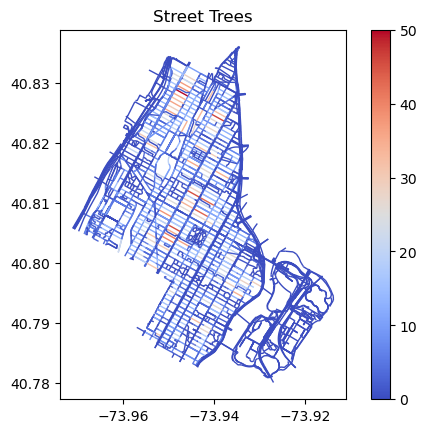

2Traffic Volumn


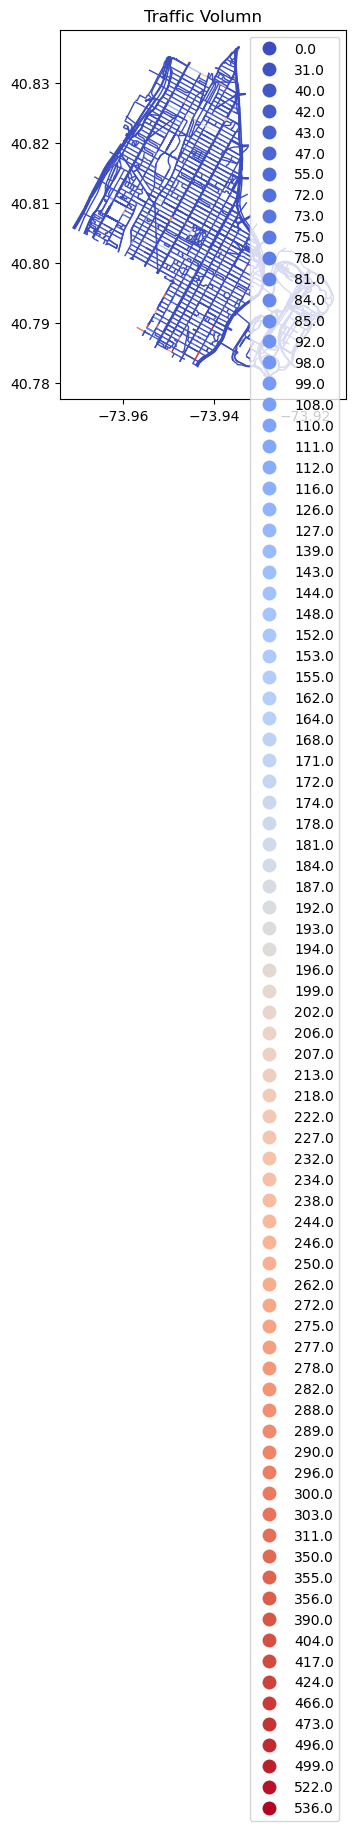

In [78]:
for i in range(0,len(conti_val)):
    print(str(i )+conti_lable[i])
    conti_plot(conti_val[i],conti_lable[i],'coolwarm')

0Non-Pedstrian Indicator


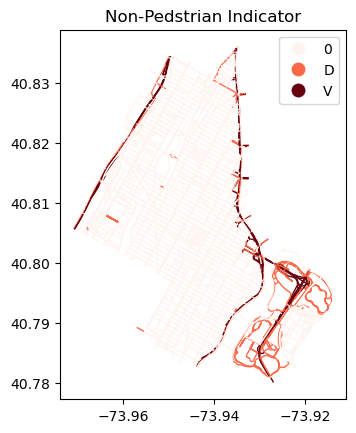

1Traffic Directions


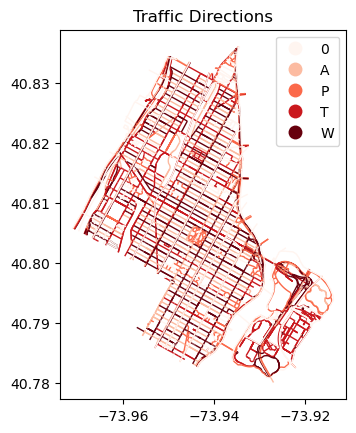

2Roadway Type


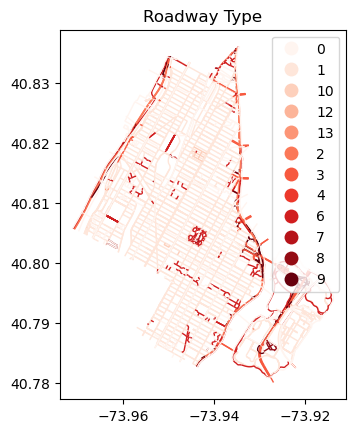

3Bikelane


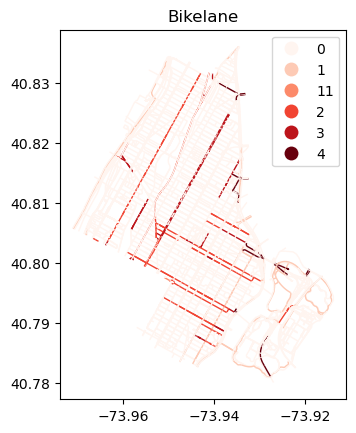

4Bike Traffic Direction


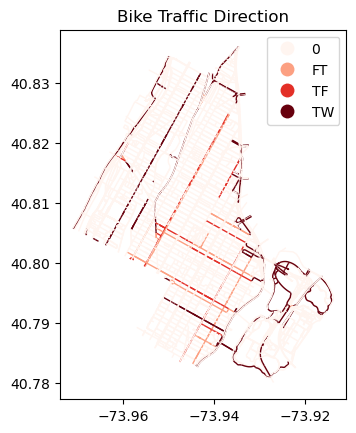

5EMM Collision happen


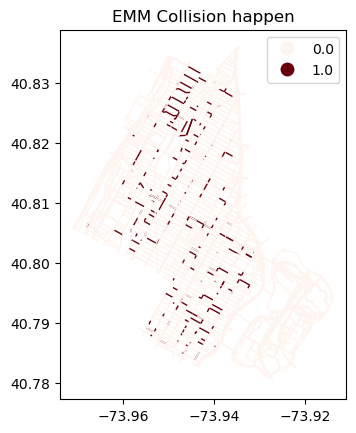

6EMM Collisions


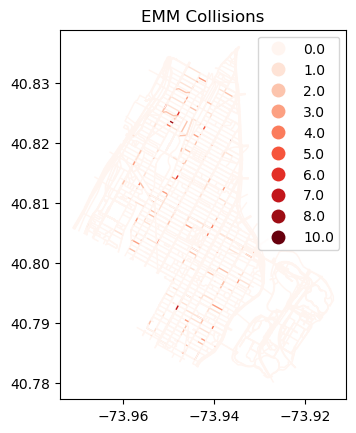

7Travel Lanes


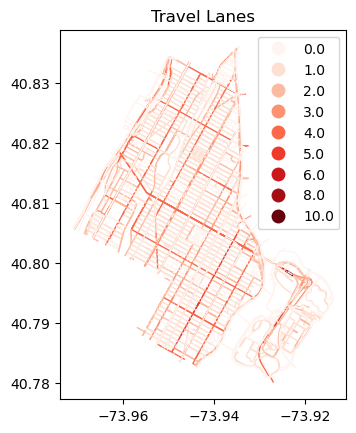

8Pedestrian Signals


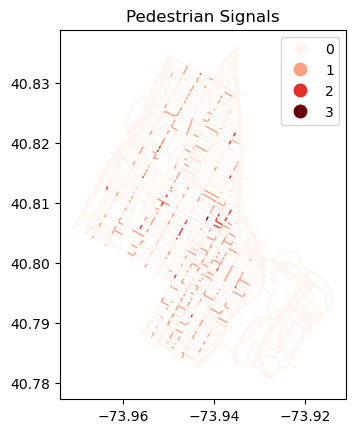

9Mobile Telecommunication Franchise pole


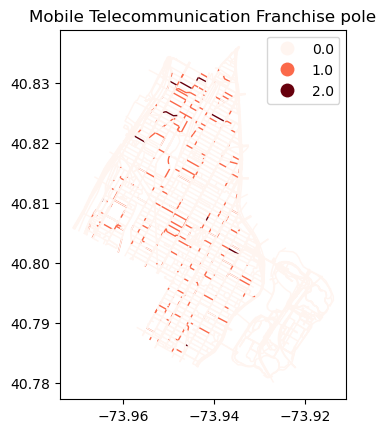

10Bus Stop Shelters


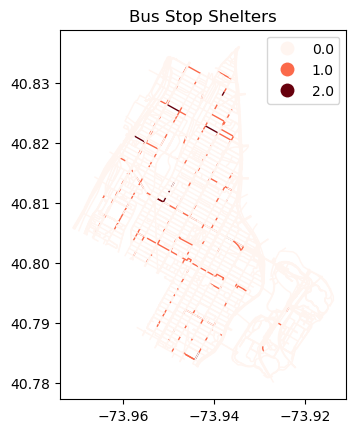

11Subway Entrances


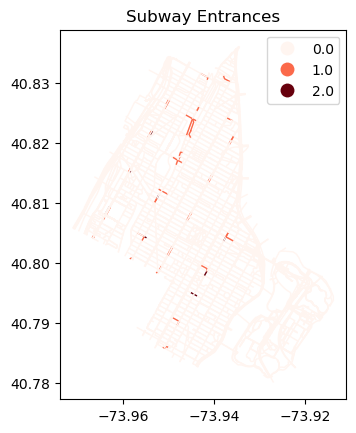

12Enhanced Crosswalk


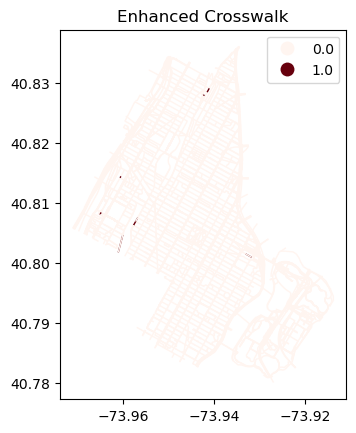

13Population


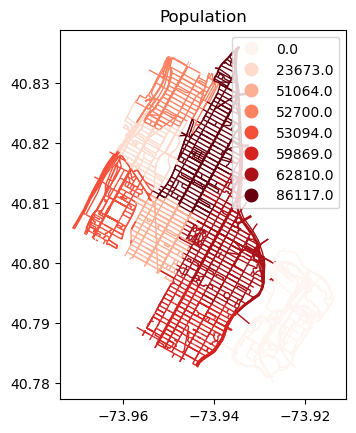

In [82]:
for i in range(0,len(cata_val)):
    print(str(i )+cata_lable[i])
    cata_plot(cata_val[i],cata_lable[i],'Reds')

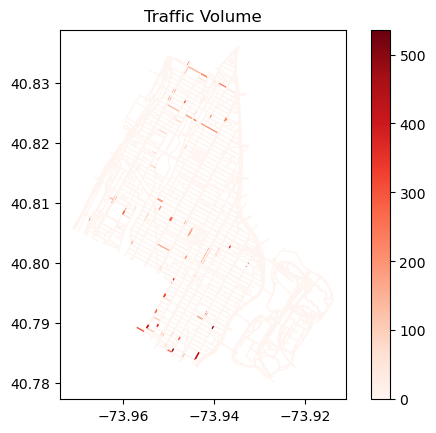

In [81]:
MN_road_geo['Vol'] = MN_road_geo[['Vol']].astype(int)
conti_plot('Vol','Traffic Volume','Reds')

## Prediction map

In [83]:
#reset road map
MN_road_geo = MN_road.merge(nyc_road[['OBJECTID','geometry']],left_on='OBJECTID',right_on='OBJECTID',how='left')

MN_road_geo = gpd.GeoDataFrame(
    MN_road_geo, geometry='geometry',crs= 2263)

MN_road_geo = MN_road_geo.to_crs(4326)

In [84]:
# prediction result from FLR in R
FLRpred = pd.read_csv('data/Edited/FLRpred.csv')

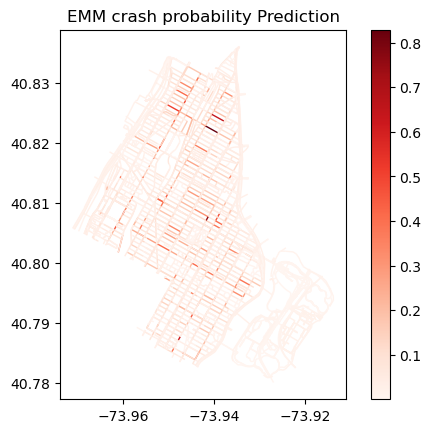

In [85]:
MN_road_geo = pd.concat([MN_road_geo,FLRpred], axis=1).rename(columns={'x':'y_pred'})
conti_plot('y_pred','EMM crash probability Prediction','Reds')

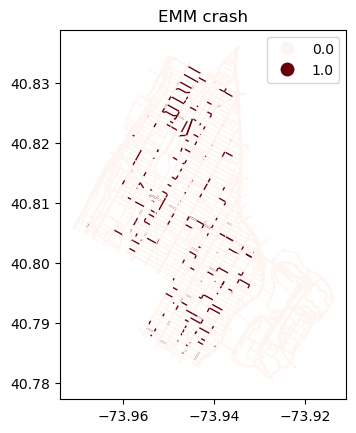

In [86]:
MN_road_geo['num_ecollisions_B']=MN_road_geo['num_ecollisions_B'].astype(object)
cata_plot('num_ecollisions_B','EMM crash','Reds')

In [87]:
# pred top 1%
MN_sort = MN_road_geo.sort_values(by='y_pred', ascending=False)
MN_001 = MN_sort[0:83]

MN_005 = MN_sort[84:418]

MN_001['top'] = 'Top 1%'
MN_005['top'] = 'Top 5%'

MN_001 = MN_001[['top']]
MN_005 = MN_005[['top']]
MN_top = MN_001.append(MN_005)

MN_road_geo = pd.concat([MN_road_geo,MN_top],axis=1)

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


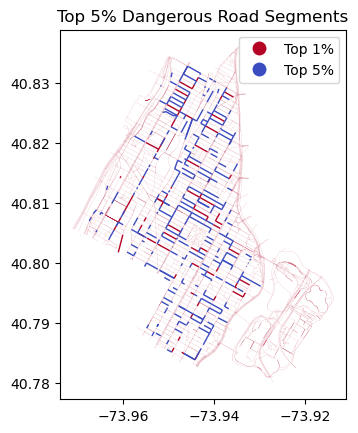

In [88]:
cata_plot('top', 'Top 5% Dangerous Road Segments','coolwarm_r')

In [89]:
MN_1 = MN_road_geo.loc[MN_road_geo['y_pred']>0.5]
MN_1['crash']= 'p>0.5'
MN_2 = MN_1[['crash']]

MN_road_geo = pd.concat([MN_road_geo,MN_2],axis=1)

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [90]:
# get dangerous road segment id
crash_road = MN_1['OBJECTID'].values.tolist()
crash_road

[91151.0, 92980.0, 96644.0, 97961.0, 98151.0, 100088.0, 103721.0]

In [91]:
m=0
for i in crash_road:
    if m==0:
        temp = nyc_road.loc[nyc_road['OBJECTID'] == i]   
        crash_set = temp
        m= m+1
    else:
        temp = nyc_road.loc[nyc_road['OBJECTID'] == i]   
        crash_set = pd.concat([crash_set,temp])
crash_set

OBJECTID            Street SAFStreetN FeatureTyp SegmentTyp IncExFlag  \
91150    91151.0      LENOX AVENUE       None          0          G      None   
92979    92980.0   WEST 148 STREET       None          0          U      None   
96643    96644.0   WEST 145 STREET       None          0          U      None   
97960    97961.0          3 AVENUE       None          0          U      None   
98150    98151.0  AMSTERDAM AVENUE       None          0          U      None   
100087  100088.0   WEST 145 STREET       None          0          U      None   
103720  103721.0          5 AVENUE       None          0          U      None   

       RB_Layer NonPed TrafDir TrafSrc  ... FromLeft ToLeft FromRight ToRight  \
91150         G   None       T     DOT  ...      481    497       488     498   
92979         B   None       A     DOT  ...      200    298       201     299   
96643         B   None       T     DCP  ...      500    598       501     599   
97960         B   None       W     DOT  ...     1786   1800      1783    1799   
98150         B   None       T     DOT  ...     1180   1198      1181    1199   
100087        B   None       T     DOT  ...      200    298       201     299   
103720        B   None       A     DOT  ...     2042   2058      2039    2057   

              Join_ID L_PD_Servi R_PD_Servi TRUCK_ROUT  SHAPE_Leng  \
91150   1301002040000       None       None       None  279.124369   
92979   1568001000000       None       None       None  875.297229   
96643   1565001000000       None       None          2  867.020317   
97960   1437001000000       None       None          2  263.785212   
98150   1053501000000       None       None          2  263.352107   
100087  1565001020000       None       None          2  875.207798   
103720  1247001040000       None       None          2  259.880630   

                                                 geometry  
91150   LINESTRING (1000485.531 235639.646, 1000621.55...  
92979   LINESTRING (1001479.867 239341.751, 1000713.09...  
96643   LINESTRING (998750.837 239936.133, 997992.088 ...  
97960   LINESTRING (998670.693 226050.450, 998798.898 ...  
98150   LINESTRING (995293.987 233699.515, 995420.499 ...  
100087  LINESTRING (1001090.727 238639.515, 1000325.57...  
103720  LINESTRING (1000369.738 233326.695, 1000495.26...  

[7 rows x 130 columns]

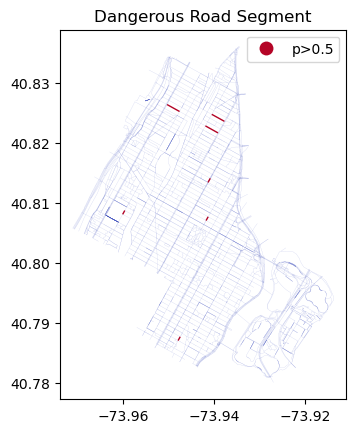

In [92]:
cmap = plt.cm.get_cmap('coolwarm')
ax = MN_road_geo.plot(linewidth = 0.1, color = cmap(1), alpha=0.5)
MN_road_geo.plot(column='crash',cmap='coolwarm_r',
                 linewidth = 1, 
                 ax=ax,legend=True)
plt.title('Dangerous Road Segment')

plt.savefig('plot/Dangerous Road Segment')

plt.show()

## lable dangerous road

In [93]:
MN_road_geo_st =  pd.merge(MN_road_geo,nyc_road[['OBJECTID','Street']],
                          left_on='OBJECTID', right_on='OBJECTID')
MN_road_geo_st.shape

(8363, 26)

In [94]:
danger_st = ['3 AVENUE',
 '5 AVENUE','AMSTERDAM AVENUE','WEST 145 STREET','LENOX AVENUE',
 'WEST 148 STREET','CLAREMONT AVENUE']

In [95]:
# label danger road
label=['A:50','B:44','C:35','D:15','E:12','F:1','G:0']

danger_road=MN_road_geo_st.loc[MN_road_geo_st['Street']==danger_st[0]]
danger_road['label']=label[0]

for i in range(1,7):
    m=MN_road_geo_st.loc[MN_road_geo_st['Street']==danger_st[i]]
    m['label']=label[i]
    danger_road = pd.concat([danger_road,m])
danger_road.head()

E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
E:\ProgramFiles\Anaconda\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

OBJECTID NonPed TrafDir RW_TYPE  StreetWidt BikeLane  num_ecollisions  \
150   91158.0      0       W       1        70.0        0              0.0   
151   91159.0      0       W       1        70.0        0              0.0   
181   91200.0      0       W       1        70.0        0              0.0   
196   91271.0      0       W       1        70.0        0              0.0   
197   91272.0      0       W       1        70.0        0              0.0   

     Number_Tra  Number_Par  POSTED_SPE  ...      pop  Vol  BIKE_TRAFD  \
150         5.0         2.0        25.0  ...  59869.0  0.0           0   
151         5.0         2.0        25.0  ...  59869.0  0.0           0   
181         5.0         2.0        25.0  ...  59869.0  0.0           0   
196         5.0         2.0        25.0  ...  62810.0  0.0           0   
197         5.0         2.0        25.0  ...  62810.0  0.0           0   

     num_ecollisions_B                                           geometry  \
150                0.0  LINESTRING (-73.94418 40.79224, -73.94372 40.7...   
151                0.0  LINESTRING (-73.94418 40.79224, -73.94372 40.7...   
181                0.0  LINESTRING (-73.94327 40.79349, -73.94281 40.7...   
196                0.0  LINESTRING (-73.94170 40.79564, -73.94142 40.7...   
197                0.0  LINESTRING (-73.94170 40.79564, -73.94142 40.7...   

       y_pred     top  crash    Street label  
150  0.042264     NaN    NaN  3 AVENUE  A:50  
151  0.047342     NaN    NaN  3 AVENUE  A:50  
181  0.134671  Top 5%    NaN  3 AVENUE  A:50  
196  0.039011     NaN    NaN  3 AVENUE  A:50  
197  0.041299     NaN    NaN  3 AVENUE  A:50  

[5 rows x 27 columns]

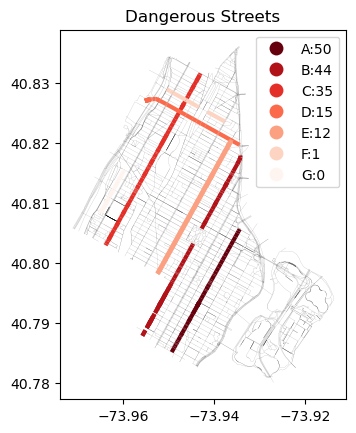

In [96]:
# plot danger road
cmap = plt.cm.get_cmap('Reds_r')
ax = MN_road_geo.plot(linewidth = 0.1, color = 'black', alpha=0.5)
danger_road.plot(column='label',cmap=cmap,
                 linewidth = 3, 
                 ax=ax,legend=True)
plt.title('Dangerous Streets')

plt.savefig('plot/Dangerous Streets')

plt.show()

# Exam dangerous streets

In [100]:
cols = ['NUMBER OF PERSONS INJURED',
 'NUMBER OF PERSONS KILLED',
 'NUMBER OF PEDESTRIANS INJURED',
 'NUMBER OF PEDESTRIANS KILLED',
 'NUMBER OF CYCLIST INJURED',
 'NUMBER OF CYCLIST KILLED',
 'NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 1',
 'CONTRIBUTING FACTOR VEHICLE 2',
 'CONTRIBUTING FACTOR VEHICLE 3',
 'CONTRIBUTING FACTOR VEHICLE 4',
 'CONTRIBUTING FACTOR VEHICLE 5',
 'COLLISION_ID',
 'VEHICLE TYPE CODE 1',
 'VEHICLE TYPE CODE 2',
 'VEHICLE TYPE CODE 3',
 'VEHICLE TYPE CODE 4',
 'VEHICLE TYPE CODE 5']

In [108]:
# function to calculate the factors on different roads
def count_elements(seq) -> dict:
    """Tally elements from `seq`."""
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

def countcra(st):
    street = collision_eco.loc[collision_eco['ON STREET NAME'] == st][cols]
    street2 = street[['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2']]
    ev = ['E-Bike','E-Scooter','E scooter','ELECTRIC S']
    factors = []

    for i in ev:
        for m in range(0,len(street2)):
            x = str(street2.apply(lambda row: row[row==i].index, axis=1).iloc[m])
            if x[8]=='V': 
                a = int(x[26])-1
                b=street2.iat[m,a]
                # print(b)
                factors.append(b)
    #count
    counted = pd.DataFrame([count_elements(factors)])
    
    #plot
    plt.rcParams['figure.figsize'] = (8.0, 6.0)  

    ax = sns.barplot(data=counted, palette="pastel")  

    plt.xticks(fontsize=15,rotation=45,ha='right')          
    plt.yticks(fontsize=15)
    plt.title(st,fontsize=20)
    plt.savefig('plot/'+st,bbox_inches = 'tight')
    plt.show()

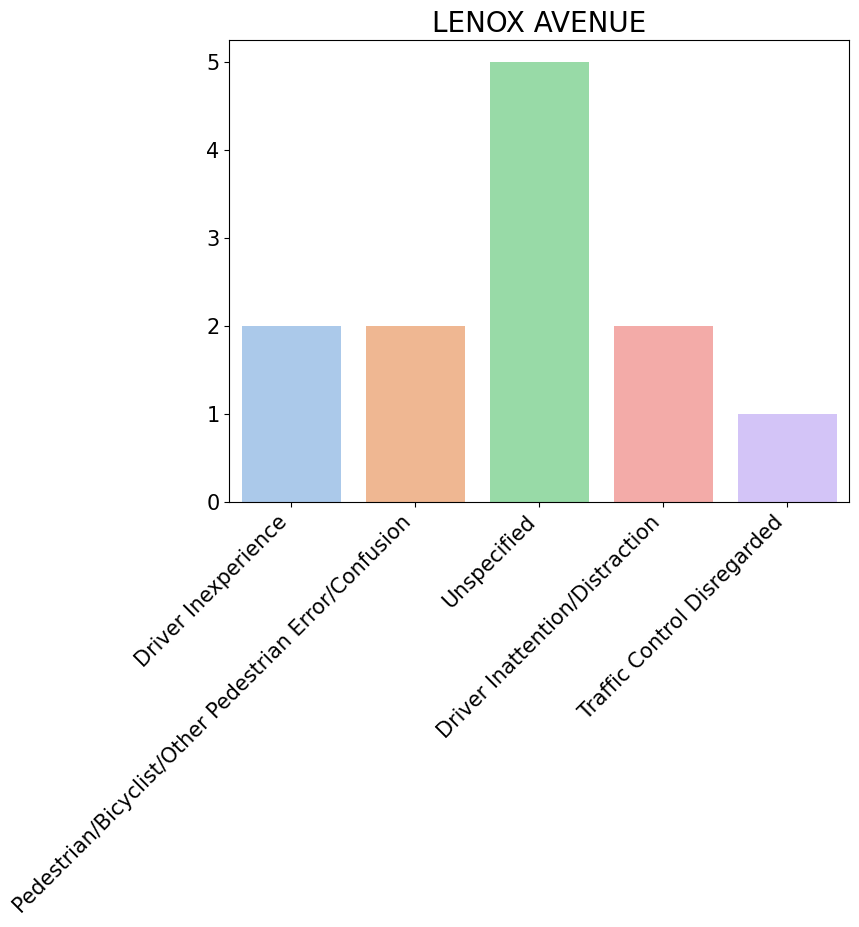

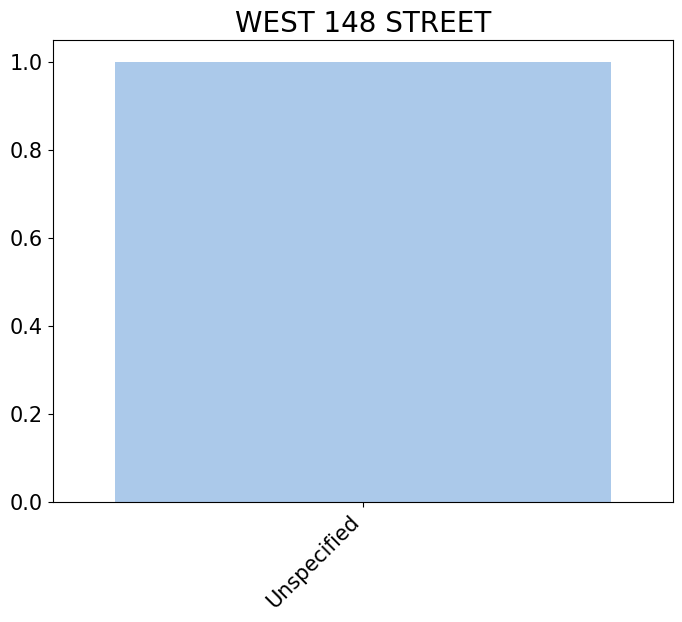

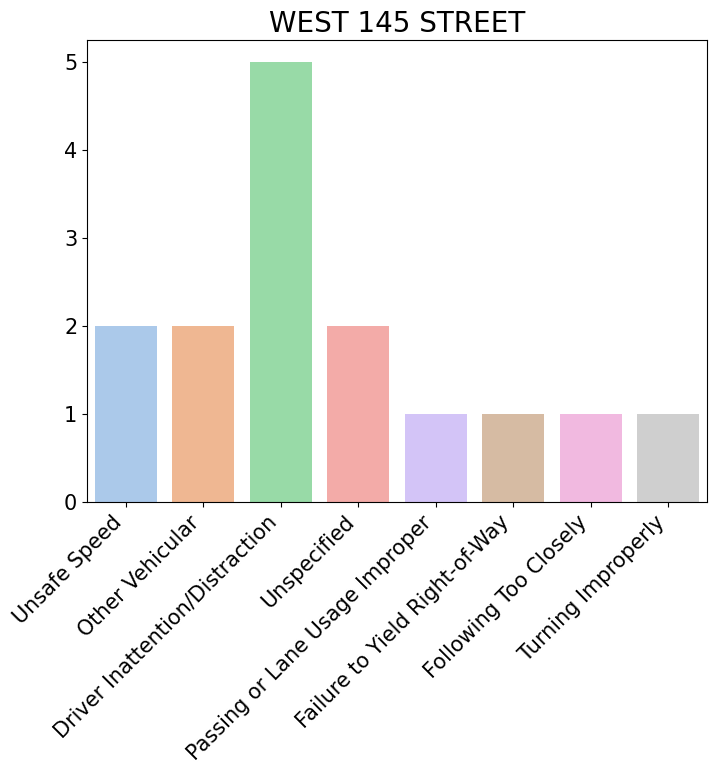

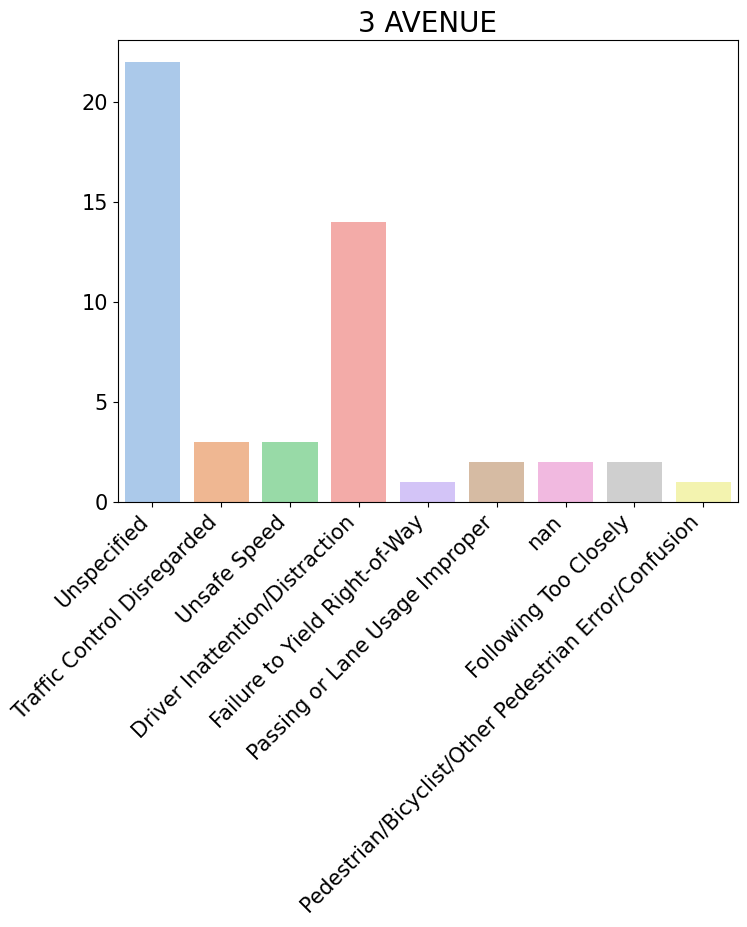

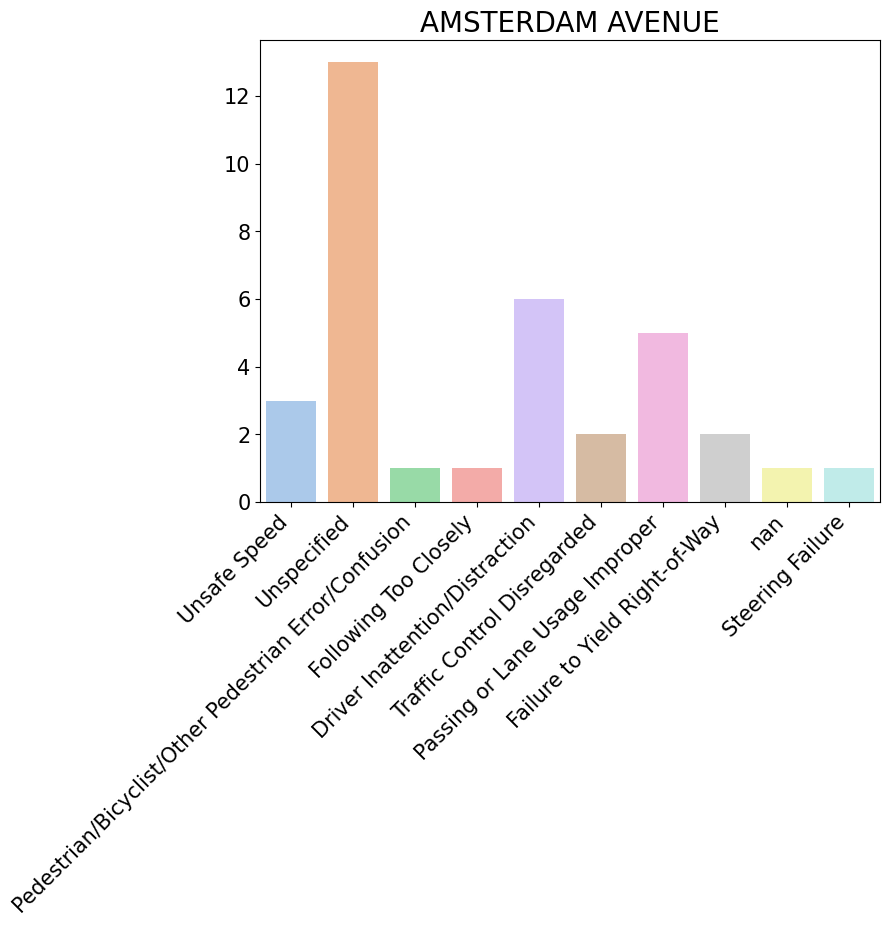

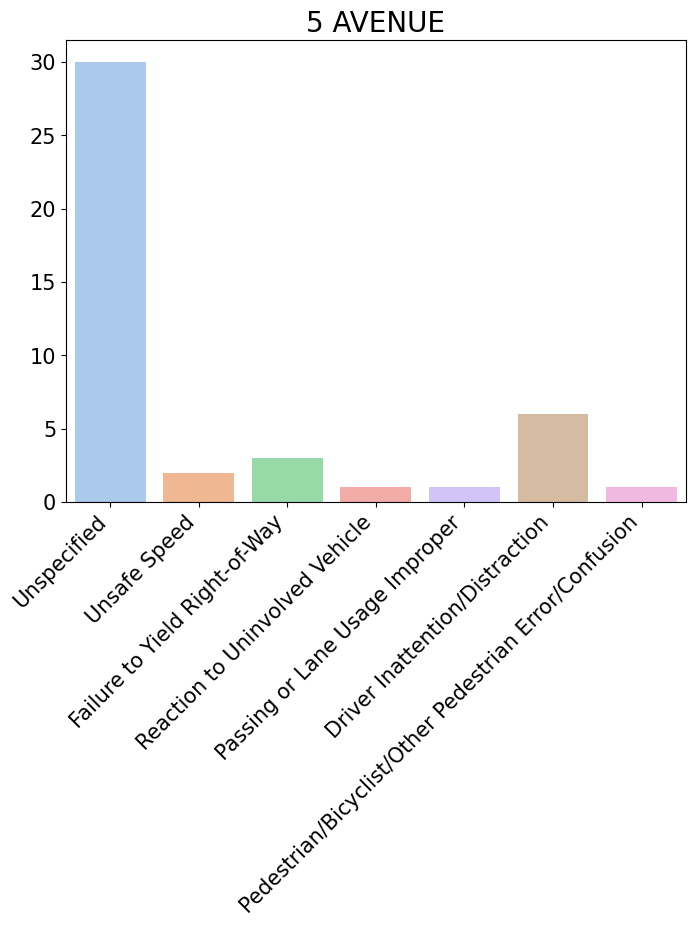

In [109]:
for i in ['LENOX AVENUE', 'WEST 148 STREET', 'WEST 145 STREET', '3 AVENUE', 'AMSTERDAM AVENUE', '5 AVENUE']:
    countcra(i)

In [102]:
tol_factors = pd.DataFrame.from_dict({'Driver Inexperience':2,
               'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion':5,
               'Driver Inattention/Distraction':33,
               'Traffic Control Disregarded':6,
               'Unsafe Speed':10,
               'Other Vehicular':2,
               'Passing or Lane Usage Improper':9,
               'Failure to Yield Right-of-Way':7,
               'Following Too Closely':4,
               'Turning Improperly':1,
               'Steering Failure':1,
               'Reaction to Uninvolved Vehicle':1},orient='index')
tol_factors

0
Driver Inexperience                                  2
Pedestrian/Bicyclist/Other Pedestrian Error/Con...   5
Driver Inattention/Distraction                      33
Traffic Control Disregarded                          6
Unsafe Speed                                        10
Other Vehicular                                      2
Passing or Lane Usage Improper                       9
Failure to Yield Right-of-Way                        7
Following Too Closely                                4
Turning Improperly                                   1
Steering Failure                                     1
Reaction to Uninvolved Vehicle                       1

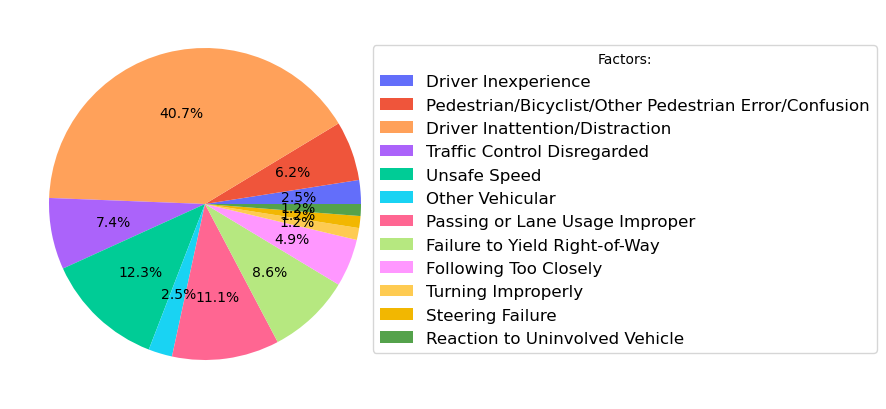

In [107]:
# Plot
plt.figure(figsize=(8,5))
# color = ['#E77C8D','#C69255','#C2D0E9','#56AD74','#5AA9A2','#5EA5C5',
#         '#A291E1','#365E91','#9E90A8','#D3B9AA','#AF8F78','#EF844A']abs
color =['#636EFA', '#EF553B', '#FFA15A', '#AB63FA', '#00CC96', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52','#F2B701','#54A24B']
plt.pie(tol_factors[0],autopct='%1.1f%%',colors=color)
plt.legend(title = "Factors:",labels=tol_factors.index, loc="center right", bbox_to_anchor=(2,0.5), bbox_transform=plt.gcf().transFigure,
          fontsize=12)
plt.subplots_adjust(left=0.0, bottom=0.1,right=2.3)

plt.savefig('plot/factor_pie',bbox_inches = 'tight')
plt.show()